## Import

In [ ]:
pip install sunpath

In [2]:
import sunpath as sp

## Data

In [3]:
dataPath = '../data/SolarPilot/'

weatherPath = dataPath + 'USA CA Daggett (TMY2).csv'

etaName = "Polar"
etaPath = dataPath + 'Polar-20MW-results-10d.csv'
# etaName = "Surround"
# etaPath = dataPath + 'Surround-100MW-results-10d.csv'

In [4]:
# clear sky irradaince
location = sp.Location(
    "Daggett, CA", 
    sp.PointGeographic(latitude=34.9*sp.degree, longitude=-116.8*sp.degree),
    sp.timedelta(hours=-8)
)
sunCalculator = sp.SunCalculator(location)
sunTemporal = sp.SunTemporal(sunCalculator)
sunTemporal.sampleYear(2021, sp.timedelta(minutes=60), sp.irradianceIneichen)

In [5]:
# measured irradiance
sunCalculator = sp.SunCalculator()
sunTemporal = sp.SunTemporal(sunCalculator)
sunTemporal.readTMY(weatherPath, tMid=0.5)

annual insolation (all elevations): 2791.424 kWh/m2
annual insolation (negative elevations): 11.163 kWh/m2


In [6]:
# import reference optical efficiency from SolarPilot
etaRef = sp.readSolarPilot(etaPath)

pEquinoxE = sp.PointEquatorial(0., 0.)
pEquinoxH = sunCalculator.findHorizontalFromEquatorial(pEquinoxE)
pEquinoxV = sunCalculator.findVectorFromEquatorial(pEquinoxE)
print(pEquinoxH)
etaRef(pEquinoxV)

azimuth = 180.000d, elevation = 55.133d


0.6931110544085451

In [7]:
# build grids (for contour plots, meshless interpolation, grid interpolation)
sunSpatialPlot = sp.SunSpatial(sunCalculator)
sunSpatialPlot.sampleEquatorial(2*sp.degree)
sunSpatialPlot.info()

sunSpatial = sp.SunSpatial(sunCalculator)
rho = 2*sunCalculator.obliquity/2
sunSpatial.sampleEquatorial(rho) 
sunSpatial.info()

sunSpatialRect = sp.SunSpatial(sunCalculator)
rho = 2*sunCalculator.obliquity/2
sunSpatialRect.sampleEquatorial(rho, True) 
sunSpatialRect.info()

points: 2184
points: 27
points: 27


In [8]:
# init plotters
if etaName == 'Polar':
    levelsEta = [0., 0.72, 0.1]
    labelPositionsE = [(2.5, -10), (3.7, -10)]
    labelPositionsH = [(270, 20), (250, 45)]
elif etaName == 'Surround':
    levelsEta = [0., 0.65, 0.1]
    labelPositionsE = [(2.5, -10), (3.7, -10)]
    labelPositionsH = [(270, 20), (250, 45)]

sunPlotter = sp.SunPlotter(
    sunSpatialPlot, sunSpatial,
    levelsEta, labelPositionsE, labelPositionsH)

sunPlotterRect = sp.SunPlotter(
    sunSpatialPlot, sunSpatialRect,
    levelsEta, labelPositionsE, labelPositionsH)

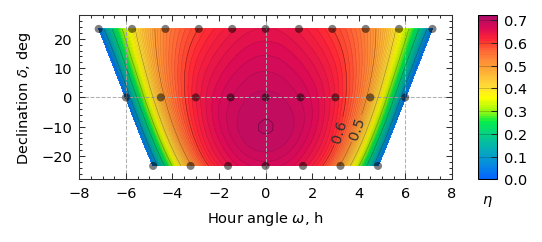

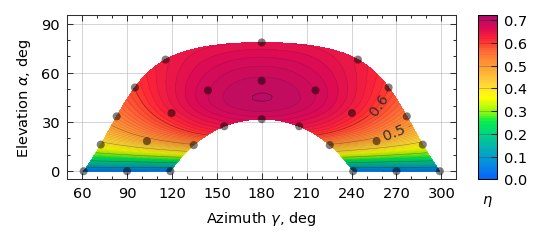

In [9]:
# contour plots for reference efficiency
figure = sunPlotter.showEquatorial(etaRef)
# figure.savefig(etaName + "EtaRefE.pdf", dpi=300)

figure = sunPlotter.showHorizontal(etaRef)
# figure.savefig(etaName + "EtaRefH.pdf", dpi=300)

## Interpolation

delta_rms = 1.014%
delta_m = -0.521%
delta_wm = -0.351%


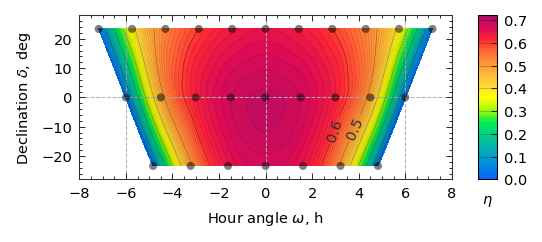

In [10]:
methodTri = sp.InterpolationMethod('triangular', order=2)
etaTri = sp.MakeInterpolation(sunSpatial, etaRef, methodTri)
sunTemporal.checkAccuracy(etaTri, etaRef)
# sunSpatial.checkAccuracy(etaTri, etaRef)
# sunSpatialPlot.checkAccuracy(etaTri, etaRef)
figure = sunPlotter.showEquatorial(etaTri)

delta_rms = 0.459%
delta_m = 0.053%
delta_wm = 0.036%


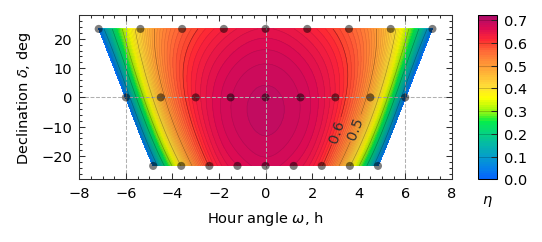

In [11]:
methodBS = sp.InterpolationMethod('B-spline', order=[3, 2])
etaBS = sp.MakeInterpolation(sunSpatialRect, etaRef, methodBS) 
sunTemporal.checkAccuracy(etaBS, etaRef)
figure = sunPlotterRect.showEquatorial(etaBS)

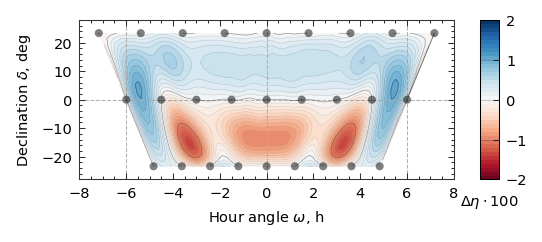

In [12]:
figure = sunPlotterRect.showEquatorial(lambda v: 100*(etaBS(v) - etaRef(v)),
    levels=[-2, 2, 1], cmap=sp.cm.RdBu, cbarTitle=r"$\Delta\eta\cdot100$", labelPositions=[])

delta_rms = 0.670%
delta_m = 0.020%
delta_wm = -0.008%


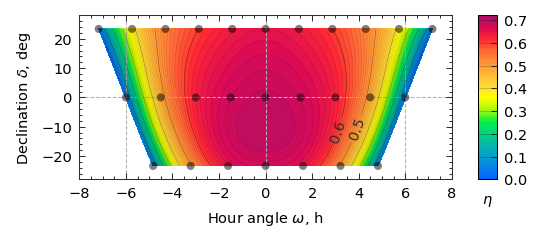

In [13]:
methodRBF2D = sp.InterpolationMethod('RBF-2D', kernel='quintic')
etaRBF2D = sp.MakeInterpolation(sunSpatial, etaRef, methodRBF2D)
sunTemporal.checkAccuracy(etaRBF2D, etaRef)
figure = sunPlotter.showEquatorial(etaRBF2D)

In [14]:
pFunc = lambda s: 1
# pFunc = lambda s: 1 + s.z
# pFunc = lambda s: math.exp(1*s.z)

delta_rms = 0.467%
delta_m = 0.062%
delta_wm = -0.005%


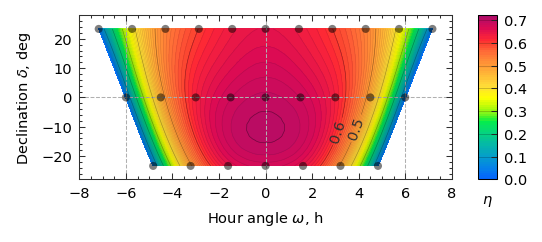

In [15]:
methodRBFg = sp.InterpolationMethod('RBF-3D', kernel='gaussian', sigma=2.5*rho, precondition=pFunc)
etaRBFg = sp.MakeInterpolation(sunSpatial, etaRef, methodRBFg)
sunTemporal.checkAccuracy(etaRBFg, etaRef)
figure = sunPlotter.showEquatorial(etaRBFg)

delta_rms = 0.383%
delta_m = 0.063%
delta_wm = 0.035%


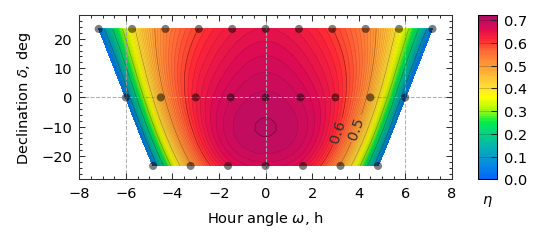

In [16]:
methodRBF = sp.InterpolationMethod('RBF-3D', kernel='polyharmonic', order=5, precondition=pFunc)
etaRBF = sp.MakeInterpolation(sunSpatial, etaRef, methodRBF)
sunTemporal.checkAccuracy(etaRBF, etaRef)
figure = sunPlotter.showEquatorial(etaRBF)

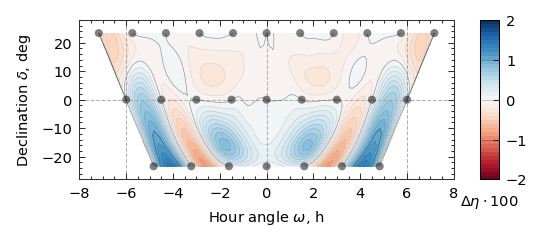

In [17]:
figure = sunPlotter.showEquatorial(lambda v: 100*(etaRBF(v) - etaRef(v)),
    levels=[-2, 2, 1], cmap=sp.cm.RdBu, cbarTitle=r"$\Delta\eta\cdot100$", labelPositions=[])

## Weights

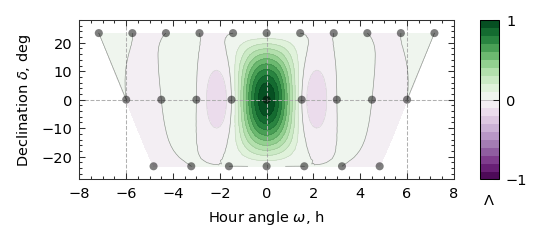

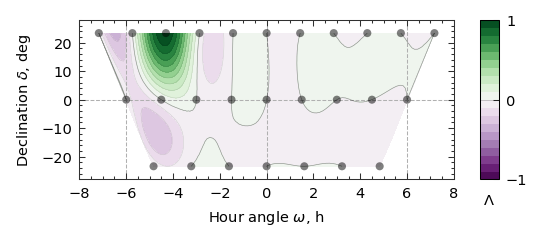

In [18]:
methodRBFn = sp.InterpolationMethod('RBF-3D', kernel='polyharmonic', order=5, precondition=pFunc)
for n in [11, 18]:
    methodRBFn.node = n
    etaRBFn = sp.MakeInterpolation(sunSpatial, etaRef, methodRBFn)
    figure = sunPlotter.showEquatorial(etaRBFn,     
        levels=[-1, 1, 1], cmap=sp.cm.PRGn, cbarTitle=r"$\Lambda$", labelPositions=[])
    # figure.savefig("Lambda-" + str(n) + ".pdf", dpi=300)

In [19]:
methodRBFn = sp.InterpolationMethod('RBF-3D', kernel='polyharmonic', order=5, precondition=pFunc)
methodRBFn.findWeights(sunTemporal, sunSpatial, etaRef)

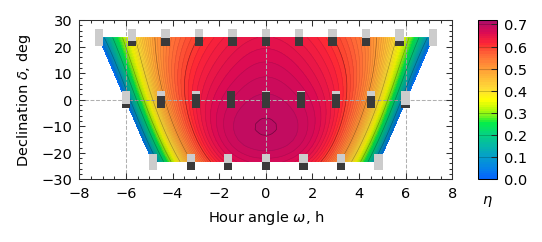

In [20]:
figure = sunPlotter.showEquatorial(etaRBF, labelPositions=[], showWeights=True)

In [21]:
diff = methodRBFn.checkDiff(sunTemporal, sunSpatial, etaRef)
print('diff = {:.3f}%'.format(100*diff))

diff = 0.035%
